In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
sys.path.append("../2_train_models")
from file_configs import MergedFilesConfig
#sys.path.append("../5_modisco")

from other_motif_utils import compute_per_position_ic, plot_motif_on_ax

In [3]:
cell_type = "K562"
model_type = "strand_merged_umap"
data_type = "procap"

in_window = 2114
out_window = 1000

In [4]:
# need to specify for every expt

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

In [5]:
config = MergedFilesConfig(cell_type, model_type, data_type)

proj_dir = config.proj_dir

figures_dir = proj_dir + "figures/"

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

slice_len = config.slice

peak_path = config.all_peak_path

modisco_results_path = config.modisco_profile_results_path

In [6]:
from load_annotations_utils import load_coords_with_summits

coords = load_coords_with_summits(peak_path, in_window=in_window)

In [7]:
from data_loading import extract_observed_profiles

true_profs = extract_observed_profiles(config.plus_bw_path,
                                       config.minus_bw_path,
                                       peak_path,
                                       out_window=out_window)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [8]:
def trim_multiple_motifs_by_thresh(motifs, trim_threshold=0.3, pad=2):
    starts = []
    ends = []
    for motif in motifs:
        trim_thresh = np.max(motif) * trim_threshold
        pass_inds = np.where(motif >= trim_thresh)[0]

        start = max(np.min(pass_inds) - pad, 0)
        end = min(np.max(pass_inds) + pad + 1, len(motif) + 1)
        
        starts.append(start)
        ends.append(end)
    
    start = min(*starts)
    end = max(*ends)
    
    return [motif[start:end] for motif in motifs]



def extract_profs_at_seqlets(seqlets, coords, profs,
                             in_window, out_window, slice_len, prof_width=200):
    
    def seqlet_coord_to_profile_coord(seqlet_coord):
        return seqlet_coord + ((in_window - slice_len) // 2) - ((in_window - out_window) // 2)
        
    coord_indexes = seqlets["example_idx"][:]
    seqlet_starts = seqlets["start"][:]
    seqlet_ends = seqlets["end"][:]
    seqlet_rcs = seqlets["is_revcomp"][:]
    
    # Get indices of profile above seqlet
    seqlet_centers = (seqlet_starts + seqlet_ends) // 2
    prof_centers = seqlet_coord_to_profile_coord(seqlet_centers)
    prof_starts = prof_centers - prof_width
    prof_ends = prof_starts + prof_width * 2
    
    # For each seqlet, fetch the true/predicted profiles
    seqlet_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, prof_starts, prof_ends, seqlet_rcs):
        if prof_start < 0 or prof_end > out_window:
            # don't use profile for this example since indexes go past the profile end  - Kelly
            prof = np.full((profs.shape[-2], prof_width * 2), np.nan)
        else:
            prof = profs[coord_index, :, prof_start:prof_end]
        
        if rc:
            prof = prof[::-1, ::-1]
        
        seqlet_profs.append(prof)  
    
    seqlet_profs = np.stack(seqlet_profs)
    return seqlet_profs


def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False,
                     color = None, tick_len=3, tick_fontsize=6):
    assert len(profiles.shape) == 3

    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]
    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    
    profs_norm = normalize(profiles, axis=-1)

    # Compute the mean profiles across all examples
    profs_mean = np.mean(profs_norm, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color=color, linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color=color, alpha = 0.6, linewidth=0.5)

    # Set axes
    max_mean_val = np.max(profs_mean)
    
    if tick_len < 3:
        mean_ylim = max_mean_val * 1.1  # Make 5% higher
    else:
        mean_ylim = max_mean_val * 1.
        
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        for side in ["left", "top", "right", "bottom"]:
            ax.spines[side].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=tick_fontsize)
        ax.tick_params("x", length=tick_len)
        
        for side in ["left", "top", "right"]:
            ax.spines[side].set_visible(False)
            
        if tick_len < 3:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 6, mean_ylim / 7,
                                     clip_on=False, zorder=50, color="white")
        else:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                     clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        


def plot_pattern_mult_subpatterns_and_profs(pfm, cwm, profs1, profs2,
                                      pfm_subs, cwm_subs, profs1_subs, profs2_subs,
                                      ylabel=None, save_path = None):

    pwm = pfm * compute_per_position_ic(pfm)[:, None]
    pwm_subs = [pfm_sub * compute_per_position_ic(pfm_sub)[:, None] for pfm_sub in pfm_subs]
    
    trims = trim_multiple_motifs_by_thresh([pwm, cwm, *pwm_subs, *cwm_subs])
    
    # unpack output (hacky)
    pwm_trim = trims[0]
    cwm_trim = trims[1]
    pwm_subs_trim = trims[2 : 2 + len(pwm_subs)]
    cwm_subs_trim = trims[2 + len(pwm_subs) : ]
    
    assert len(pwm_subs_trim) == len(cwm_subs_trim), (len(pwm_subs_trim), len(cwm_subs_trim))
    assert len(pwm_subs_trim) == len(profs1_subs), (len(pwm_subs_trim), len(profs1_subs))
    assert len(profs1_subs) == len(profs2_subs), (len(profs1_subs), len(profs2_subs))
    
    
    fig, axes = plt.subplots(1 + len(pwm_subs), 4,
                             figsize=(4.5,0.45 + 0.475 * len(pwm_subs)),
                             dpi=300)
    
    ax_i = 0
    plot_motif_on_ax(pwm_trim, axes[0, 0])
    plot_motif_on_ax(cwm_trim, axes[0, 1])
    
    plot_avg_profile(profs1, axes[0, 2], color = "#001DAC")
    plot_avg_profile(profs2, axes[0, 3], color = "#1B5AE3")

    for i in range(len(pwm_subs_trim)):
        plot_motif_on_ax(pwm_subs_trim[i], axes[i + 1, 0])
        plot_motif_on_ax(cwm_subs_trim[i], axes[i + 1, 1])

        plot_avg_profile(profs1_subs[i], axes[i + 1, 2], color = "#001DAC",
                         bottom_ticks = i == len(pwm_subs_trim) - 1,
                         tick_len=2)
        axes[i + 1, 2].tick_params("x", labelsize=6)
        plot_avg_profile(profs2_subs[i], axes[i + 1, 3], color = "#1B5AE3",
                         bottom_ticks = i == len(pwm_subs_trim) - 1,
                         tick_len=2)
        axes[i + 1, 3].tick_params("x", labelsize=6)
    
    
    top_fontsize=6
    lpad=22
    lpad2=-0.37
    if ylabel is not None:
        axes[0, 0].set_ylabel(ylabel + "\nPattern", fontsize=top_fontsize,
                              rotation=0, labelpad=lpad)
        axes[0, 0].yaxis.set_label_coords(lpad2, .25)
        
        if len(pwm_subs_trim) == 1:
            axes[1, 0].set_ylabel(ylabel + "-Inr\nSub-Pattern",
                                      fontsize=top_fontsize, rotation=0, labelpad=lpad)
            axes[1, 0].yaxis.set_label_coords(lpad2, 0.25)
        else:
            for i in range(len(pwm_subs_trim)):
                axes[i + 1, 0].set_ylabel(ylabel + "-Inr\nSub-Pattern\n" + str(i+1),
                                          fontsize=top_fontsize, rotation=0, labelpad=lpad)
                axes[i + 1, 0].yaxis.set_label_coords(lpad2, 0.05)
    
    axes[0,0].set_title("PWM", fontsize=top_fontsize, y=1.2)
    axes[0,1].set_title("CWM", fontsize=top_fontsize, y=1.2)
    axes[0,2].set_title("Avg. Observed\nProfile", fontsize=top_fontsize)
    axes[0,3].set_title("Avg. Predicted\nProfile", fontsize=top_fontsize)
        
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0., dpi = 300)
    
    plt.show()

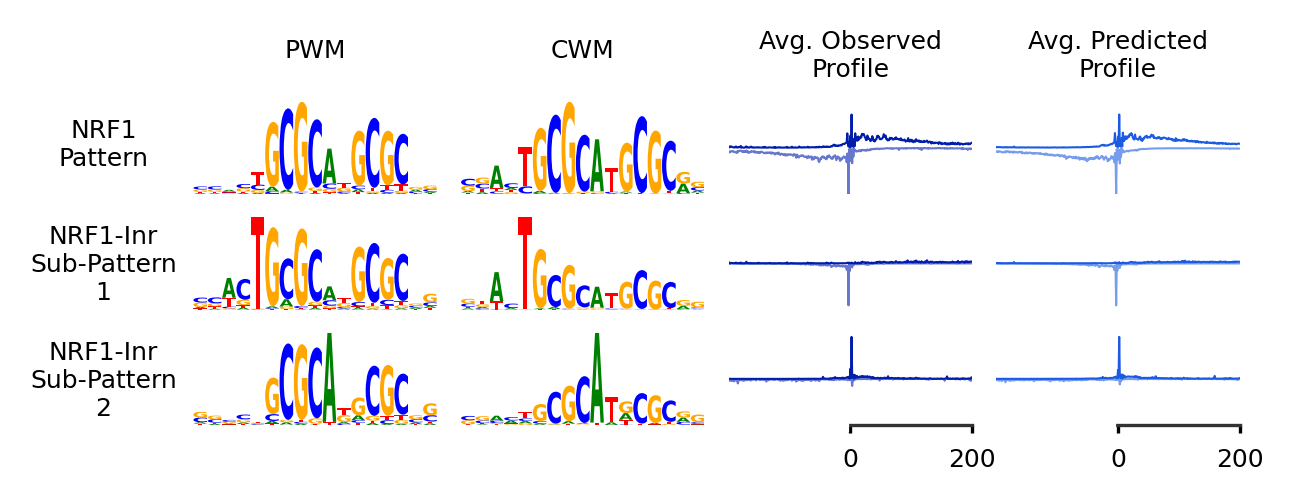

In [10]:
def plot_multi_subclusters(modisco_results_path, pattern_i, subpattern_is, save_dir = None):
    new_f = h5py.File(modisco_results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
    assert pattern_group_name in new_f.keys(), pattern_group_name
    
    new_patterns_grp = new_f[pattern_group_name]

    assert len(new_patterns_grp.keys()) > 0, pattern_group_name

    # get info for pattern overall
    
    pattern_grp = new_patterns_grp["pattern_" + str(patterns_to_keep[pattern_i])]

    sequence = pattern_grp["sequence"]
    contrib_scores = pattern_grp["contrib_scores"]
    hypothetical_contribs = pattern_grp["hypothetical_contribs"]
    seqlets = pattern_grp["seqlets"]

    true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                       true_profs, in_window, out_window, slice_len)
    pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                       pred_profs, in_window, out_window, slice_len)

    # get info for sub-pattern
    sub_sequences = []
    sub_contrib_scores = []
    true_profs_at_sub_seqlets = []
    pred_profs_at_sub_seqlets = []
    
    for subpattern_i in subpattern_is:
        subpattern_name = "subpattern_" + str(subpattern_i)

        assert subpattern_name in pattern_grp.keys(), subpattern_name

        subpattern = pattern_grp[subpattern_name]
        n_seqlets = subpattern["seqlets"]["n_seqlets"][:][0]
        sub_sequence = subpattern["sequence"]
        sub_contribs = subpattern["contrib_scores"]
        sub_seqlets = subpattern["seqlets"]

        true_profs_at_sub = extract_profs_at_seqlets(sub_seqlets, coords,
                                           true_profs, in_window, out_window, slice_len)
        pred_profs_at_sub = extract_profs_at_seqlets(sub_seqlets, coords,
                                           pred_profs, in_window, out_window, slice_len)
        
        sub_sequences.append(sub_sequence[:])
        sub_contrib_scores.append(sub_contribs[:])
        true_profs_at_sub_seqlets.append(true_profs_at_sub)
        pred_profs_at_sub_seqlets.append(pred_profs_at_sub)

    if save_dir is not None:
        save_path = save_dir + "2_combo_" + motif_names[pattern_i].replace("/", "-") + "_subs.png" 
    else:
        save_path = None
    
    plot_pattern_mult_subpatterns_and_profs(sequence[:], contrib_scores[:],
                                      true_profs_at_seqlets, pred_profs_at_seqlets,
                                      sub_sequences, sub_contrib_scores,
                                      true_profs_at_sub_seqlets, pred_profs_at_sub_seqlets,
                                      motif_names[pattern_i], save_path = save_path)
        
    new_f.close()


plot_multi_subclusters(modisco_results_path, 4, [3, 7], save_dir = figures_dir)

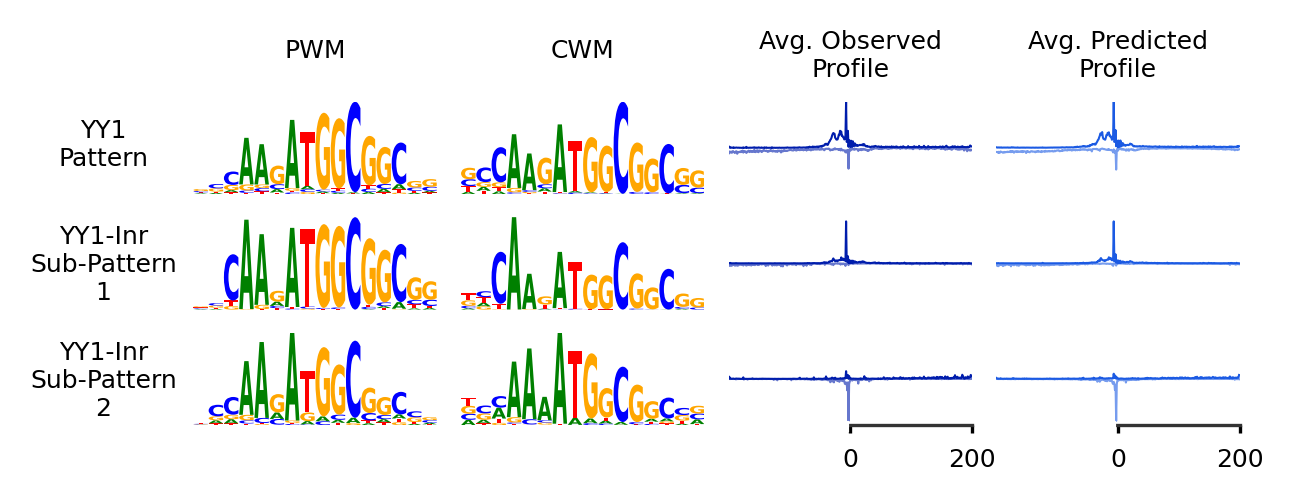

In [11]:
plot_multi_subclusters(modisco_results_path, 8, [1, 6], save_dir = figures_dir)

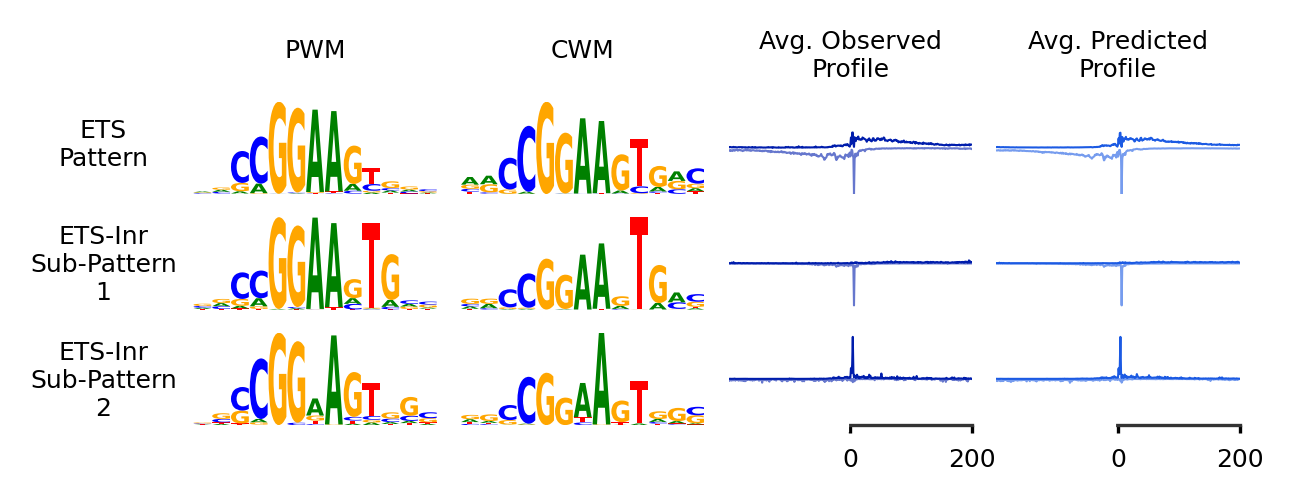

In [12]:
plot_multi_subclusters(modisco_results_path, 2, [4, 9], save_dir = figures_dir)

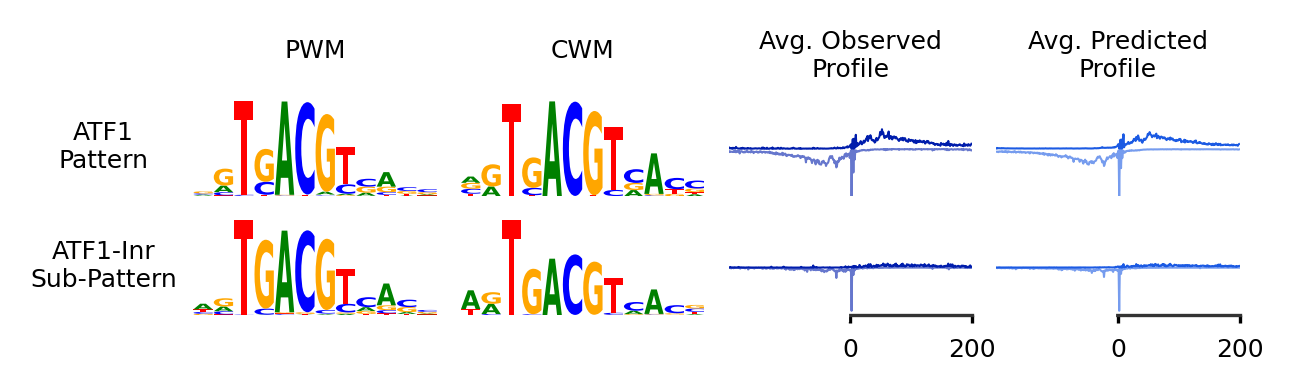

In [13]:
plot_multi_subclusters(modisco_results_path, 5, [4], save_dir = figures_dir)

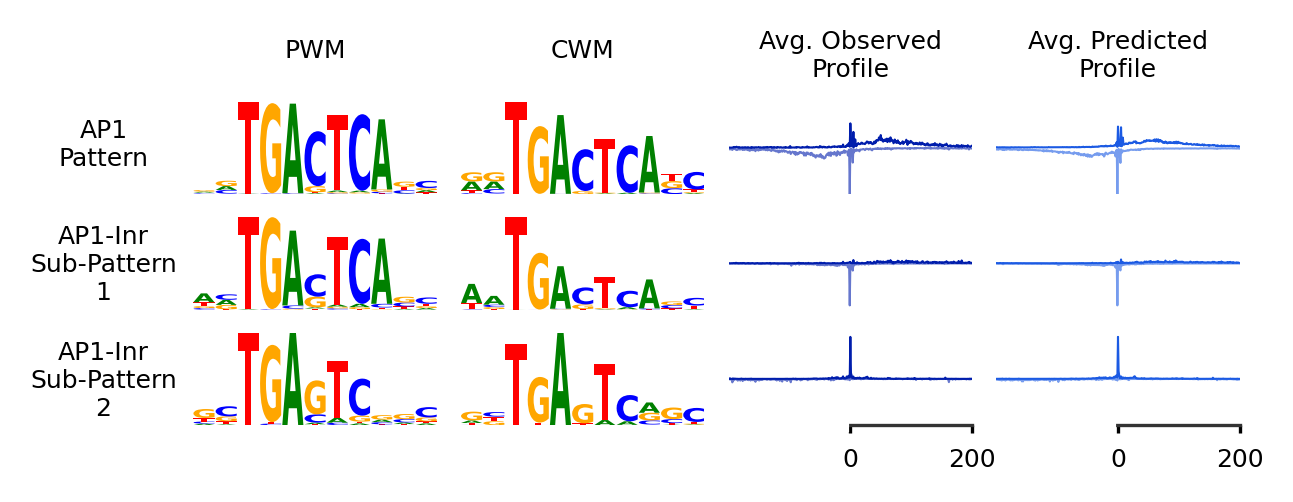

In [14]:
plot_multi_subclusters(modisco_results_path, 9, [2, 6], save_dir = figures_dir)

In [ ]:
# this is for just lookin' at all the subclusters for a given modisco hit

def plot_pattern_and_profs(pfm, cwm, profs1, profs2, ylabel=None):

    fig, axes = plt.subplots(1, 4, figsize=(8,0.6))
    axes = axes.flatten()
    
    plot_motif_on_ax(pfm, axes[0])
    plot_motif_on_ax(cwm, axes[1])
    
    plot_avg_profile(profs1, axes[2])
    plot_avg_profile(profs2, axes[3])

    if ylabel is not None:
        axes[0].set_ylabel(ylabel)

    plt.show()
    

def look_at_subclusters(modisco_results_path, pattern_i):
    new_f = h5py.File(modisco_results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
        # if the results include pos/neg patterns...
        
    if pattern_group_name in new_f.keys():
        new_patterns_grp = new_f[pattern_group_name]

        # if there are any patterns for this metacluster...

        print(pattern_group_name, " - ", len(new_patterns_grp.keys()), "motifs")

        if len(new_patterns_grp.keys()) > 0:
            pattern_grp = new_patterns_grp["pattern_" + str(pattern_i)]

            # new format
            sequence = pattern_grp["sequence"]
            contrib_scores = pattern_grp["contrib_scores"]
            #hypothetical_contribs = pattern_grp["hypothetical_contribs"]
            seqlets = pattern_grp["seqlets"]

            plt_ylabel = pattern_group_name.replace("_patterns", "") + "_" + str(pattern_i)
            
            true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                               true_profs, in_window, out_window, slice_len)
            pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                               pred_profs, in_window, out_window, slice_len)
            
            plot_pattern_and_profs(sequence[:], contrib_scores[:],
                                   true_profs_at_seqlets, pred_profs_at_seqlets, plt_ylabel)
            
            subpattern_i = 0
            while True:
                subpattern_name = "subpattern_" + str(subpattern_i)
                
                if subpattern_name not in pattern_grp.keys():
                    break
                    
                subpattern = pattern_grp[subpattern_name]
                n_seqlets = subpattern["seqlets"]["n_seqlets"][:][0]
                sequence = subpattern["sequence"]
                contrib_scores = subpattern["contrib_scores"]
                seqlets = subpattern["seqlets"]
                

                true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                                   true_profs, in_window, out_window, slice_len)
                pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, coords,
                                                   pred_profs, in_window, out_window, slice_len)

                plt_ylabel = pattern_group_name.replace("_patterns", "")
                plt_ylabel += "_"  + str(pattern_i)
                plt_ylabel += "_s" + str(subpattern_i)
                plt_ylabel += "\n" + str(n_seqlets)
                
                plot_pattern_and_profs(sequence[:], contrib_scores[:],
                                       true_profs_at_seqlets, pred_profs_at_seqlets, plt_ylabel)
                
                subpattern_i += 1
                
            
        else:
            print("No patterns in ", pattern_group_name, "?")
    else:
        print("Can't find patterns for ", pattern_group_name)
                    
    new_f.close()


_ = look_at_subclusters(modisco_results_path, 4)

## Motif Context Around Inr-Like Hits

In [11]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type, in_window)

In [57]:
import pandas as pd

def get_peaks_for_sub_seqlets(modisco_results, pattern_i, subpattern_is):
    pattern_name = "pattern_" + str(patterns_to_keep[pattern_i])
    
    new_f = h5py.File(modisco_results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
        # if the results include pos/neg patterns...
        
    sub_seqlet_peak_indexes = dict()
    if pattern_group_name in new_f.keys():
        new_patterns_grp = new_f[pattern_group_name]

        if len(new_patterns_grp.keys()) > 0:
            pattern_grp = new_patterns_grp[pattern_name]
            all_seqlets_peak_indexes = pattern_grp["seqlets"]["example_idx"][:]

            for subpattern_i in subpattern_is:
                subpattern_name = "subpattern_" + str(subpattern_i)
                    
                subpattern = pattern_grp[subpattern_name]
                sub_seqlet_peak_indexes[subpattern_i] = subpattern["seqlets"]["example_idx"][:]
            
    new_f.close()
    
    any_sub_seqlet_peak_indexes = []
    for peak_indexes in sub_seqlet_peak_indexes.values():
        any_sub_seqlet_peak_indexes.extend(peak_indexes)
        
    sub_seqlet_peak_indexes["any"] = np.array(any_sub_seqlet_peak_indexes)
    
    not_inr_peak_indexes = np.array([i for i in all_seqlets_peak_indexes if i not in sub_seqlet_peak_indexes["any"]])
    
    return not_inr_peak_indexes, sub_seqlet_peak_indexes


def make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts):
    not_inr_motifs = motif_hit_counts["profile"][not_inr_seqlet_peaks, :]
    inr_motifs = motif_hit_counts["profile"][inr_seqlet_peaks["any"], :]

    colnames_clean = [name.replace("/", "_").replace("-", "_") for name in motif_names]
    
    df = pd.DataFrame(np.concatenate((not_inr_motifs, inr_motifs)), columns = colnames_clean)
    
    # need to remove columns with no variation,
    # or else the matrix is singular can the logit fitting fails
    to_drop = []
    for colname in df.columns:
        if len(set(df[colname])) == 1:
            print("Dropping " + colname + ", no variation in hits across peaks")
            to_drop.append(colname)
    
    for drop_colname in to_drop:
        df = df.drop(drop_colname, axis=1)
    
    df["Inr_like"] = np.array([0] * len(not_inr_motifs) + [1] * len(inr_motifs))
    
    return df

In [44]:
not_inr_seqlet_peaks, inr_seqlet_peaks = get_peaks_for_sub_seqlets(modisco_results_path, 4, [3, 7])
df = make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts)

Dropping TCT, no variation in hits across peaks


In [47]:
np.sum(df["NRF1"] > 0)

3051

In [49]:
import statsmodels.formula.api as smf

log_reg = smf.logit("Inr_like ~ " + " + ".join([name for name in df.columns if name not in ["Inr_like", "NRF1"]]),
                    data=df).fit()

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.443057
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Inr_like   No. Observations:                 3390
Model:                          Logit   Df Residuals:                     3376
Method:                           MLE   Df Model:                           13
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.02584
Time:                        00:41:06   Log-Likelihood:                -1502.0
converged:                       True   LL-Null:                       -1541.8
Covariance Type:            nonrobust   LLR p-value:                 1.268e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0643      0.121    -17.048      0.000      -2.302      -1.827
BRE_SP         0.1631      0.026      6.227      0.000       0.112       0.214
CA_Inr         0.1885      0.054      3.485      0.000       0.082       0.295
ETS           -0.0680      0.057     -1.184      0.236      -0.181       0.045
NFY            0.1193      0.057      2.082      0.037       0.007       0.232
ATF1           0.0385      0.133      0.289      0.773      -0.223       0.299
TATA          -0.4000      0.313     -1.278      0.201      -1.013       0.214
THAP11         0.3022      0.113      2.684      0.007       0.081       0.523
YY1           -0.2207      0.219     -1.008      0.313      -0.650       0.208
AP1           -0.1735      0.175     -0.992      0.321      -0.516       0.169
TA_Inr        -0.2189      0.103     -2.115      0.034      -0.422      -0.016
CTCF          -0.1223      0.272     -0.449      0.654      -0.656       0.412
ZBTB33        -0.3847      0.244     -1.575      0.115      -0.863       0.094
TATATA        -0.0252      0.231     -0.109      0.913      -0.478       0.428
==============================================================================
"""

In [52]:
np.mean(df["Inr_like"][df["THAP11"] == 0]), np.mean(df["Inr_like"][df["THAP11"] > 0])

(0.16795366795366795, 0.18439716312056736)

In [53]:
np.mean(df["Inr_like"][df["BRE_SP"] == 0]), np.mean(df["Inr_like"][df["BRE_SP"] > 0])

(0.1280388978930308, 0.17850703209520374)

In [54]:
np.mean(df["Inr_like"][df["CA_Inr"] == 0]), np.mean(df["Inr_like"][df["CA_Inr"] > 0])

(0.1358555460017197, 0.1867983834755276)

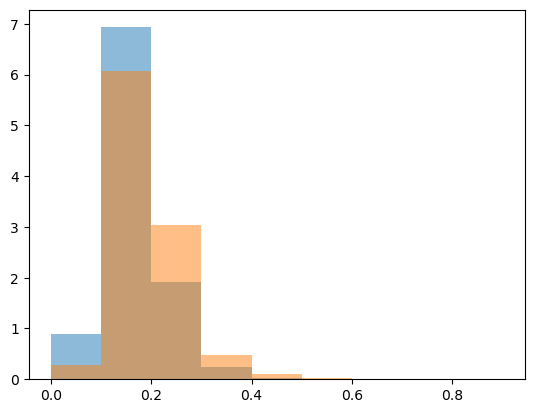

In [55]:
plt.hist(log_reg.predict(df[df["Inr_like"] == 0]), density=True, bins=np.arange(0,1,0.1), alpha=0.5)
plt.hist(log_reg.predict(df[df["Inr_like"] == 1]), density=True, bins=np.arange(0,1,0.1), alpha=0.5)
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

logit_preds = log_reg.predict(df)
roc_auc_score(df["Inr_like"], logit_preds)

0.6143762868229331

In [60]:
not_inr_seqlet_peaks, inr_seqlet_peaks = get_peaks_for_sub_seqlets(modisco_results_path, 8, [1, 6])
df = make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts)
np.sum(df["YY1"] > 0), df["YY1"].shape

(597, (1053,))

In [61]:
log_reg = smf.logit("Inr_like ~ " + " + ".join([name for name in df.columns if name not in ["Inr_like", "YY1"]]),
                    data=df).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.522214
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Inr_like   No. Observations:                 1053
Model:                          Logit   Df Residuals:                     1038
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.02497
Time:                        00:49:47   Log-Likelihood:                -549.89
converged:                       True   LL-Null:                       -563.98
Covariance Type:            nonrobust   LLR p-value:                   0.01351
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4123      0.229     -6.181      0.000      -1.860      -0.964
BRE_SP         0.1096      0.037      2.923      0.003       0.036       0.183
CA_Inr        -0.0698      0.096     -0.728      0.466      -0.258       0.118
ETS           -0.0914      0.088     -1.036      0.300      -0.264       0.082
NFY           -0.0007      0.069     -0.011      0.991      -0.137       0.135
NRF1           0.0521      0.090      0.576      0.564      -0.125       0.229
ATF1           0.1258      0.175      0.720      0.471      -0.216       0.468
TATA           0.1387      0.355      0.390      0.696      -0.557       0.835
THAP11        -0.3925      0.228     -1.719      0.086      -0.840       0.055
AP1           -0.3532      0.273     -1.292      0.196      -0.889       0.183
TA_Inr        -0.0683      0.156     -0.437      0.662      -0.374       0.238
CTCF           0.3851      0.372      1.035      0.301      -0.344       1.115
ZBTB33         0.0590      0.212      0.278      0.781      -0.356       0.474
TCT            1.2159      0.569      2.138      0.033       0.101       2.330
TATATA         0.5281      0.290      1.821      0.069      -0.040       1.097
==============================================================================
"""

In [62]:
np.mean(df["Inr_like"][df["BRE_SP"] == 0]), np.mean(df["Inr_like"][df["BRE_SP"] > 0])

(0.14465408805031446, 0.24161073825503357)

In [63]:
logit_preds = log_reg.predict(df)
roc_auc_score(df["Inr_like"], logit_preds)

0.5930396924120773

In [65]:
not_inr_seqlet_peaks, inr_seqlet_peaks = get_peaks_for_sub_seqlets(modisco_results_path, 2, [4, 9])
df = make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts)
np.sum(df["ETS"] > 0), df["ETS"].shape

(4999, (5506,))

In [68]:
log_reg = smf.logit("Inr_like ~ " + " + ".join([name for name in df.columns if name not in ["Inr_like", "ETS"]]),
                    data=df).fit(maxiter=10000)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.318627
         Iterations 2083


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Inr_like   No. Observations:                 5506
Model:                          Logit   Df Residuals:                     5491
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                 0.04133
Time:                        00:55:02   Log-Likelihood:                -1754.4
converged:                       True   LL-Null:                       -1830.0
Covariance Type:            nonrobust   LLR p-value:                 3.999e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8675      0.112    -25.540      0.000      -3.088      -2.647
BRE_SP         0.2134      0.023      9.088      0.000       0.167       0.259
CA_Inr         0.1607      0.054      2.954      0.003       0.054       0.267
NFY            0.1569      0.049      3.180      0.001       0.060       0.254
NRF1           0.1375      0.058      2.357      0.018       0.023       0.252
ATF1          -0.2185      0.140     -1.565      0.117      -0.492       0.055
TATA          -0.3401      0.265     -1.285      0.199      -0.859       0.179
THAP11         0.5085      0.094      5.411      0.000       0.324       0.693
YY1           -0.4474      0.231     -1.936      0.053      -0.900       0.006
AP1           -0.1659      0.131     -1.268      0.205      -0.422       0.091
TA_Inr        -0.0161      0.096     -0.167      0.867      -0.204       0.172
CTCF           0.7427      0.248      2.999      0.003       0.257       1.228
ZBTB33        -0.1659      0.233     -0.712      0.476      -0.622       0.291
TCT          -35.9738    4.3e+07  -8.37e-07      1.000   -8.42e+07    8.42e+07
TATATA         0.1617      0.174      0.927      0.354      -0.180       0.504
==============================================================================
"""

In [69]:
np.mean(df["Inr_like"][df["BRE_SP"] == 0]), np.mean(df["Inr_like"][df["BRE_SP"] > 0])

(0.06424792139077853, 0.11570643079129811)

In [70]:
np.mean(df["Inr_like"][df["CA_Inr"] == 0]), np.mean(df["Inr_like"][df["CA_Inr"] > 0])

(0.08930190389845875, 0.11272727272727273)

In [71]:
np.mean(df["Inr_like"][df["NFY"] == 0]), np.mean(df["Inr_like"][df["NFY"] > 0])

(0.09778933680104031, 0.11619506321493077)

In [72]:
np.mean(df["Inr_like"][df["THAP11"] == 0]), np.mean(df["Inr_like"][df["THAP11"] > 0])

(0.0994671403197158, 0.1480637813211845)

In [73]:
np.mean(df["Inr_like"][df["CTCF"] == 0]), np.mean(df["Inr_like"][df["CTCF"] > 0])

(0.1015190811411634, 0.19444444444444445)

In [74]:
logit_preds = log_reg.predict(df)
roc_auc_score(df["Inr_like"], logit_preds)

0.6488651561520502

In [79]:
not_inr_seqlet_peaks, inr_seqlet_peaks = get_peaks_for_sub_seqlets(modisco_results_path, 5, [4])
df = make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts)
np.sum(df["ATF1"] > 0), df["ATF1"].shape

(1855, (2265,))

In [80]:
log_reg = smf.logit("Inr_like ~ " + " + ".join([name for name in df.columns if name not in ["Inr_like", "ATF1"]]),
                    data=df).fit(maxiter=10000)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.305992
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Inr_like   No. Observations:                 2265
Model:                          Logit   Df Residuals:                     2250
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                0.009014
Time:                        01:01:40   Log-Likelihood:                -693.07
converged:                       True   LL-Null:                       -699.38
Covariance Type:            nonrobust   LLR p-value:                    0.5576
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1234      0.207    -10.242      0.000      -2.530      -1.717
BRE_SP        -0.0004      0.044     -0.008      0.993      -0.087       0.087
CA_Inr        -0.0409      0.086     -0.474      0.636      -0.210       0.128
ETS            0.0260      0.089      0.292      0.770      -0.148       0.200
NFY           -0.0409      0.091     -0.452      0.651      -0.218       0.136
NRF1          -0.0894      0.094     -0.956      0.339      -0.273       0.094
TATA           0.4233      0.314      1.347      0.178      -0.193       1.039
THAP11        -0.2360      0.304     -0.776      0.438      -0.832       0.360
YY1            0.0576      0.271      0.213      0.832      -0.473       0.589
AP1           -0.2024      0.212     -0.955      0.340      -0.618       0.213
TA_Inr        -0.3878      0.170     -2.279      0.023      -0.721      -0.054
CTCF           0.5007      0.410      1.221      0.222      -0.303       1.304
ZBTB33         0.1210      0.359      0.337      0.736      -0.582       0.824
TCT            0.3664      1.091      0.336      0.737      -1.771       2.504
TATATA         0.2573      0.277      0.929      0.353      -0.285       0.800
==============================================================================
"""

In [81]:
logit_preds = log_reg.predict(df)
roc_auc_score(df["Inr_like"], logit_preds)

0.5708353609083536

In [82]:
not_inr_seqlet_peaks, inr_seqlet_peaks = get_peaks_for_sub_seqlets(modisco_results_path, 9, [2, 6])
df = make_motif_hits_vs_inr_func_df(not_inr_seqlet_peaks, inr_seqlet_peaks, motif_hit_counts)
np.sum(df["AP1"] > 0), df["AP1"].shape

(837, (975,))

In [85]:
# needed to remove TCT to converge
log_reg = smf.logit("Inr_like ~ " + " + ".join([name for name in df.columns if name not in ["Inr_like", "AP1", "TCT"]]),
                    data=df).fit(maxiter=10000)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.471452
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Inr_like   No. Observations:                  975
Model:                          Logit   Df Residuals:                      961
Method:                           MLE   Df Model:                           13
Date:                Fri, 15 Sep 2023   Pseudo R-squ.:                  0.1293
Time:                        01:04:42   Log-Likelihood:                -459.67
converged:                       True   LL-Null:                       -527.90
Covariance Type:            nonrobust   LLR p-value:                 1.072e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2481      0.208    -10.790      0.000      -2.657      -1.840
BRE_SP         0.3704      0.057      6.545      0.000       0.259       0.481
CA_Inr         0.2051      0.097      2.122      0.034       0.016       0.395
ETS            0.3847      0.118      3.251      0.001       0.153       0.617
NFY           -0.0343      0.103     -0.333      0.739      -0.236       0.168
NRF1           0.4289      0.156      2.748      0.006       0.123       0.735
ATF1           0.3002      0.289      1.040      0.298      -0.266       0.866
TATA          -1.7130      0.594     -2.886      0.004      -2.876      -0.550
THAP11         1.0254      0.382      2.686      0.007       0.277       1.774
YY1            0.1515      1.253      0.121      0.904      -2.305       2.608
TA_Inr        -0.0611      0.166     -0.369      0.712      -0.386       0.264
CTCF           1.4864      0.922      1.613      0.107      -0.320       3.293
ZBTB33         2.2162      0.828      2.676      0.007       0.593       3.839
TATATA        -0.2121      0.268     -0.792      0.429      -0.737       0.313
==============================================================================
"""

In [100]:
np.mean(df["Inr_like"][df["BRE_SP"] == 0]), np.mean(df["Inr_like"][df["BRE_SP"] > 0]), np.sum(df["BRE_SP"] > 0)

(0.14917127071823205, 0.2805872756933116, 613)

In [90]:
np.mean(df["Inr_like"][df["ETS"] == 0]), np.mean(df["Inr_like"][df["ETS"] > 0])

(0.20440251572327045, 0.2831858407079646)

In [99]:
np.mean(df["Inr_like"][df["NRF1"] == 0]), np.mean(df["Inr_like"][df["NRF1"] > 0]), np.sum(df["NRF1"] > 0)

(0.2028985507246377, 0.3945578231292517, 147)

In [98]:
np.mean(df["Inr_like"][df["TATA"] == 0]), np.mean(df["Inr_like"][df["TATA"] > 0]), np.sum(df["TATA"] > 0)

(0.2494407158836689, 0.037037037037037035, 81)

In [97]:
np.mean(df["Inr_like"][df["THAP11"] == 0]), np.mean(df["Inr_like"][df["THAP11"] > 0]), np.sum(df["THAP11"] > 0)

(0.220231822971549, 0.6538461538461539, 26)

In [94]:
np.mean(df["Inr_like"][df["ZBTB33"] == 0]), np.mean(df["Inr_like"][df["ZBTB33"] > 0]), np.sum(df["ZBTB33"] > 0)

(0.22590673575129533, 0.8, 10)

In [86]:
logit_preds = log_reg.predict(df)
roc_auc_score(df["Inr_like"], logit_preds)

0.7405035622718197